# Chess games analysis
Author: Tomas Suchockas

Dataset source: https://www.kaggle.com/arevel/chess-games/tasks?taskId=5580
In this work Chess games taken from the LiChess platform were analysed.

Data columns used:
1. Event - Chess game type played
2. White - White piece player username
3. Black - Black piece player username
4. Result - Game result
5. WhiteElo - White piece player ELO ranking
6. BlackElo - Black piece player ELO ranking
7. Opening - Opening name
8. Termination - The way the game ended

Calculated data columns:
1. EloDifference - ELO difference between the players
2. HigherEloColor - The played color of the higher ELO player

Hypothesies/questions to answer using the data:
1. In what elo range were there the most games played?
2. Players that have a higher ELO by at least a hundred have an 80% winrate.
3. Players of a lower ranking win by getting a "mate".
4. What are the most popular openings?
5. What is the most popular game type played?
6. Most games end by way of mate.
7. White piece players win more than black piece players.

## Library importing, data cleaning

In [1]:
import pandas as pd
import mysql.connector
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import math
import numpy as np
mydb = mysql.connector.connect(host='localhost', port=3317, user='root', password='Minedas323?')
cursor = mydb.cursor(buffered=True)
cursor.execute('CREATE SCHEMA IF NOT EXISTS `chess`;')
cursor.execute('USE chess;')

### Data uploading to a database from CSV file

In [5]:
# function to save a read line from file to database
def save_line_to_db(line):
    try: 
        line = line.replace(', ', '; ')
        vertes = line.split(',')
        if len(vertes) == 15:
            sql_insert = f'''INSERT INTO chess_games_python VALUES ('''
            for j in vertes:
                j = j.replace('"','')
                j = j.replace('; ', ', ')
                if j != vertes[-1]:
                    sql_insert += f'"{j}",'
                else:
                    sql_insert += f'"{j}");'
            cursor.execute(sql_insert)
            mydb.commit()
            return True
        else:
            return False
    except:
        print(f"{sql_insert} ERORR IN QUERY")

In [6]:
# Opening the file for reading
file = open(r"C:\Users\Lenovo\Desktop\Data backup\Datasets\chess_games.csv", 'r')
# Creating a table in database to store the data
create_table = '''
CREATE TABLE IF NOT EXISTS `chess_games_python` (
  `Event` text COLLATE utf8_lithuanian_ci,
  `White` text COLLATE utf8_lithuanian_ci,
  `Black` text COLLATE utf8_lithuanian_ci,
  `Result` text COLLATE utf8_lithuanian_ci,
  `UTCDate` text COLLATE utf8_lithuanian_ci,
  `UTCTime` text COLLATE utf8_lithuanian_ci,
  `WhiteElo` int DEFAULT NULL,
  `BlackElo` int DEFAULT NULL,
  `WhiteRatingDiff` double DEFAULT NULL,
  `BlackRatingDiff` double DEFAULT NULL,
  `ECO` text COLLATE utf8_lithuanian_ci,
  `Opening` text COLLATE utf8_lithuanian_ci,
  `TimeControl` text COLLATE utf8_lithuanian_ci,
  `Termination` text COLLATE utf8_lithuanian_ci,
  `AN` text COLLATE utf8_lithuanian_ci
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb3 COLLATE=utf8_lithuanian_ci;
'''
cursor.execute(create_table)

# Writing the data from file to database line by line
read_count = 0
wrote_count = 0
while True:
    read_count += 1
    line = file.readline()
    if read_count > 1:
        if save_line_to_db(line):
            wrote_count += 1
    if not line:
        break
file.close()
print(f"Wrote {wrote_count}/{read_count - 1} rows to database")

INSERT INTO chess_games_python VALUES (" Blitz ","irakli112233","irakli1811","1-0","2016.06.30","22:00:54","1500","1500","","","A00","Van't Kruijs Opening","300+0","Normal","1. e3 f5 2. d3 g5 3. Qh5# 1-0
"); ERORR IN QUERY
INSERT INTO chess_games_python VALUES (" Blitz ","irakli112233","irakli1811","1-0","2016.06.30","22:01:59","1500","1500","","","C57","Italian Game: Two Knights Defense, Fried Liver Attack","300+0","Normal","1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. exd5 Nxd5 6. Nxf7 Kxf7 7. Qh5+ g6 8. Bxd5+ Kf6 9. Bf7 gxh5 10. Bg6 Kxg6 1-0
"); ERORR IN QUERY
INSERT INTO chess_games_python VALUES (" Blitz ","ZUMOSOL","pawnimpact0007","1-0","2016.06.30","22:19:53","2180","1393","","","A40","Englund Gambit Complex: Soller Gambit","300+0","Normal","1. d4 e5 2. dxe5 f6 3. exf6 Nxf6 4. Bg5 Bc5 5. Nc3 Bxf2+ 6. Kxf2 O-O 7. Nf3 c6 8. Qd4 d5 9. e3 Ne4+ 10. Nxe4 1-0
"); ERORR IN QUERY
INSERT INTO chess_games_python VALUES (" Classical ","IvanIsPlayingChess","ChessCurry30","0-1","2016.06.30","

### Reading data from database and cleaning it

In [2]:
df = pd.read_sql("SELECT Event, White, Black, Result, WhiteElo, BlackElo, Opening, Termination FROM chess_games_python;", mydb)

In [3]:
def parse_winning_color(row):
    if row['Result'] == '1-0':
        return 'White'
    if row['Result'] == '0-1':
        return 'Black'
    if row['Result'] == '1/2-1/2':
        return 'Draw'

In [4]:
df['Winner'] = df.apply(parse_winning_color, axis='columns')

In [5]:
def calculate_elo_difference(row):
    return math.sqrt((row['WhiteElo'] - row['BlackElo']) ** 2)
df['EloDifference'] = df.apply(calculate_elo_difference, axis='columns')

In [6]:
def write_player_higher_elo(row):
    if row['WhiteElo'] > row['BlackElo']:
        return 'White'
    if row['WhiteElo'] < row['BlackElo']:
        return 'Black'
    if row['WhiteElo'] == row['BlackElo']:
        return 'Equal'
df['HigherEloColor'] = df.apply(write_player_higher_elo, axis='columns')

In [7]:
df['Event'] = df['Event'].map(lambda x: x.strip())

In [8]:
# Function to show values in chart
def show_values(axs, orient="v", space=.01, whole_number=True):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                if whole_number == True:
                    value = '{}'.format(int(p.get_height()))
                else:
                    value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                if whole_number == True:
                    value = '{}'.format(int(p.get_height()))
                else:
                    value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## In what elo range were there the most games played?
6.2 million games were analysed in total. In order to get to know the data better a histogram was made, grouped by ELO increments of 200.

In [9]:
elo_groups_games_count = (df.groupby((df['WhiteElo']//200)*200)['WhiteElo'].count()).reset_index(name='Games count')

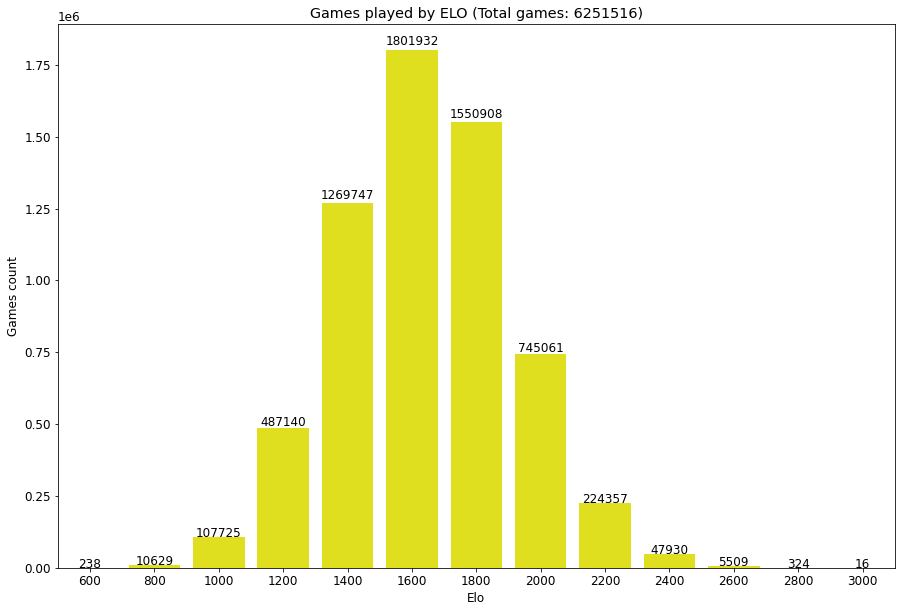

In [10]:
games_count = df['Opening'].count()
matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x='WhiteElo', y='Games count', data=elo_groups_games_count, color='yellow')
ax.set(xlabel='Elo', ylabel='Games count', title=f'Games played by ELO (Total games: {games_count})')
show_values(ax)

Looking at the histogram it is clear that the games recorded are between 600 and 3000 ELO, while the most amount of games played were between 1400 and 1800 ELO.

## Players that have a higher ELO by at least a hundred have an 80% winrate.
To check this hypothesis games with an ELO difference of atleast 100 were taken and grouped by increment of 100. Afterwards the winning percentage of all the groups was calculated and presented in a bar grapgh.

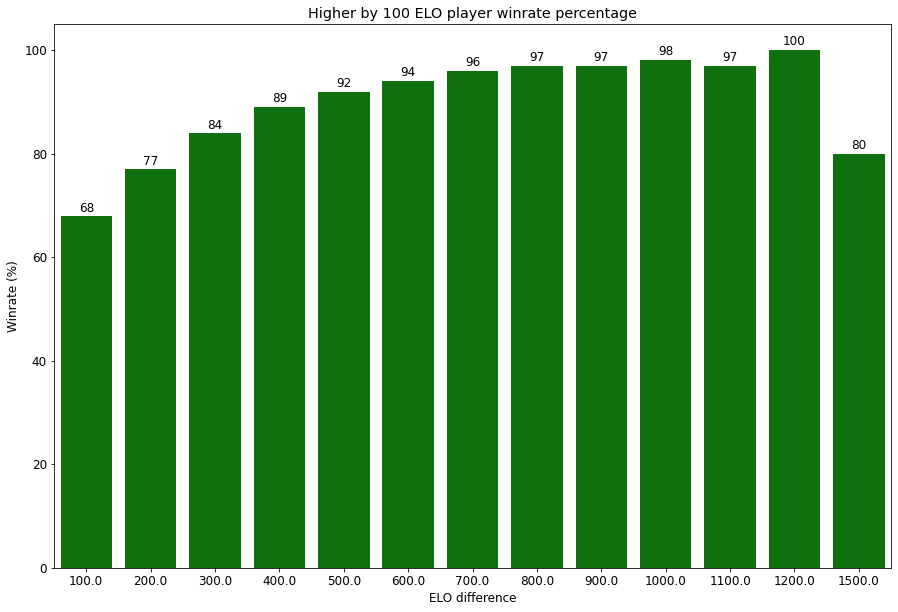

In [12]:
lower_elo_winners = df[(df['Winner'] != 'Draw') & (df['Winner'] != df['HigherEloColor']) & (df['EloDifference'] > 100)].sort_values(by=['EloDifference'], ascending=False)
lower_df_games = df[df['EloDifference'] > 100]
lower_df_games = pd.DataFrame((lower_df_games.groupby(((lower_df_games['EloDifference']//100)*100))['Result'].count()).reset_index(name="Total games"))
lower_df = pd.DataFrame(((lower_elo_winners.groupby((lower_elo_winners['EloDifference']//100)*100))['Result'].count()).reset_index(name="Lower win"))
lower_elo_df = pd.merge(lower_df_games, lower_df, on='EloDifference')
lower_elo_df['HigherWinPercentage'] = (100 - (lower_elo_df['Lower win'] / lower_elo_df['Total games']) * 100).round()

chart = sns.barplot(x='EloDifference', y='HigherWinPercentage', data=lower_elo_df, color='green')
plt.title("Higher by 100 ELO player winrate percentage")
plt.ylabel('Winrate (%)')
plt.xlabel('ELO difference')
show_values(chart)

Looking at the chart it is clear that in games where the ELO difference was 100 the winrate of higher ELO players is 68% and the hypothesis is correct only when the difference in ELO is 300. Going further along the chart the winrate keeps increasing until 1000 ELO difference, then it goes down a bit. Between 1200 and 1500 ELO difference the winrate drops by 20%.

## Players of a lower ranking win by getting a "mate".
Victory in chess can be reached not only via mate. A player can win by:
1. Abandon - a player leaves the game
2. A player gets a "mate"
3. Rules infraction
4. A player runs out of time to perform their move.

To test this hypothesis all the games where the player with lower elo won was counted and grouped by the way the game ended and shown in a bar chart.

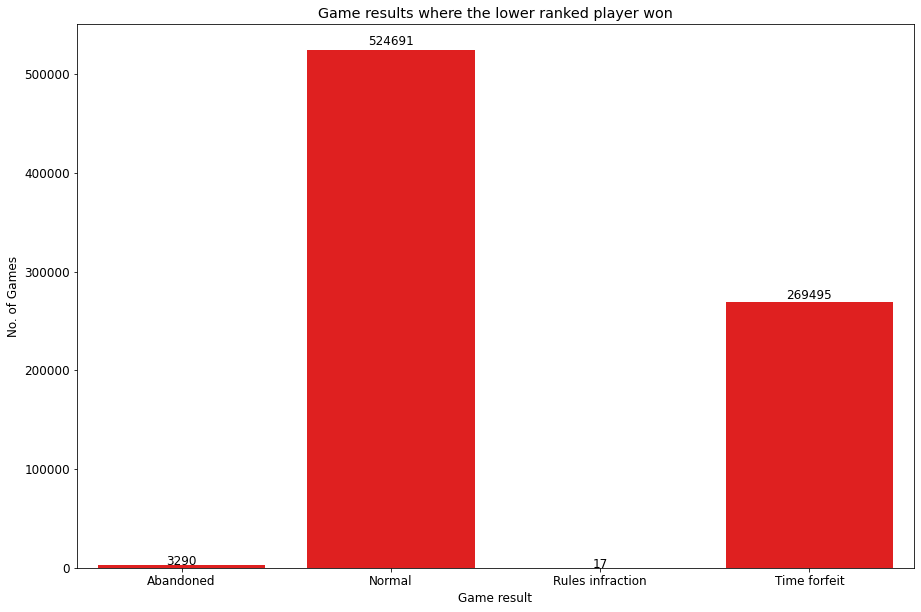

In [19]:
lower_elo_win_types = pd.DataFrame(lower_elo_winners.groupby('Termination')['Result'].count()).reset_index()
lower_elo_win_types['Result']
chart = sns.barplot(x='Termination', y='Result', data=lower_elo_win_types, color='red', ci=None)
plt.xlabel('Game result')
plt.ylabel('No. of Games')
plt.title('Game results where the lower ranked player won')
show_values(chart)

The chart shows that the most games were won via mate, the hypothesis is confirmed.

## What are the most popular openings?
An opening is the initial state of a chess game. Standart openings are defined by names. The popularity of openings was checked by aggregating their names by ELO groups and presenting the data in a table.

In [14]:
openings_by_elo_group = (df.groupby([((df['WhiteElo']//200)*200), 'Opening'])['Opening'].count()).reset_index(name="Count")
openings_by_elo_group = (openings_by_elo_group.groupby(['WhiteElo', 'Opening'])['Count'].max()).reset_index()
top_openings_by_elo_group = pd.DataFrame(openings_by_elo_group.groupby(['WhiteElo'], sort=False)['Count'].max())
white_openings = pd.merge(top_openings_by_elo_group, openings_by_elo_group, on=['WhiteElo', 'Count'], how='inner')

white_openings = white_openings[white_openings['Count'] > 1]
openings_by_elo_group = (df.groupby([((df['BlackElo']//200)*200), 'Opening'])['Opening'].count()).reset_index(name="Count")
openings_by_elo_group = (openings_by_elo_group.groupby(['BlackElo', 'Opening'])['Count'].max()).reset_index()
top_openings_by_elo_group = pd.DataFrame(openings_by_elo_group.groupby(['BlackElo'], sort=False)['Count'].max())
black_openings = pd.merge(top_openings_by_elo_group, openings_by_elo_group, on=['BlackElo', 'Count'], how='inner')
black_openings = black_openings[black_openings['Count'] > 1].reset_index()

all_openings = pd.merge(white_openings, black_openings, left_on='WhiteElo', right_on='BlackElo', how='left').reset_index()
columns_to_drop = ['level_0','index','BlackElo']
all_openings.drop(columns_to_drop, axis=1, inplace=True)
all_openings.rename({'WhiteElo': 'Elo', 'Count_x': 'White count', 'Opening_x':'White opening', 'Count_y':'Black count', 'Opening_y':'Black opening'}, inplace=True, axis='columns')

display(HTML(all_openings.to_html()))

The data shows that white piece players, between 600 and 1600 ELO used the "Van't Kruijs Opening" opening, the same is true for black piece players, except in the 600 ELO range, in which the "Scandinavian Defense" was the most popular. Top 3 openings overall were:
1. Van't Kruijs Opening
2. Modern Defense
3. Old Benoni Defense

## What is the most popular game type played?
Chess can be played in a few different ways. The main difference between game types is the time given to perform moves. In order to answer the posed question games were grouped by their type. After grouping the percentage of games played was counted and shown in a bar chart.

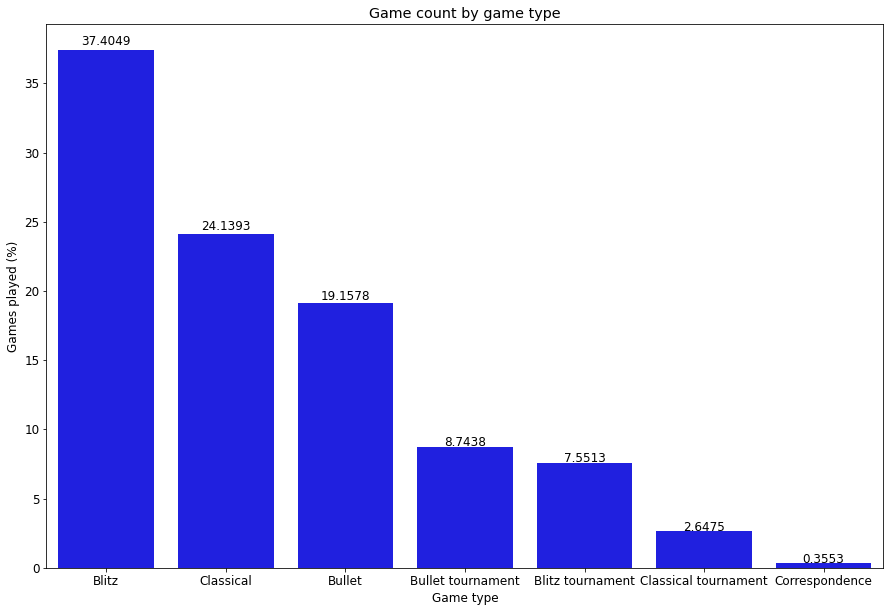

In [15]:
game_modes = df.groupby('Event')['Event'].count().reset_index(name='Event count').sort_values(by=['Event count'], ascending=False)
game_modes['Game percentage'] = (game_modes['Event count'] / games_count) * 100

chart = sns.barplot(x='Event', y='Game percentage', data=game_modes, color='blue')
plt.title('Game count by game type')
plt.xlabel('Game type')
plt.ylabel('Games played (%)')
show_values(chart, whole_number=False)

The chart shows that the most popular game type is "Blitz".

## Most games end by way of mate.
As stated earlier a chess match can end in one of four ways. In order to test this hypothesis all games were grouped by the ways they ended. After grouping the percentage of games won was calculated and shown in a bar chart.

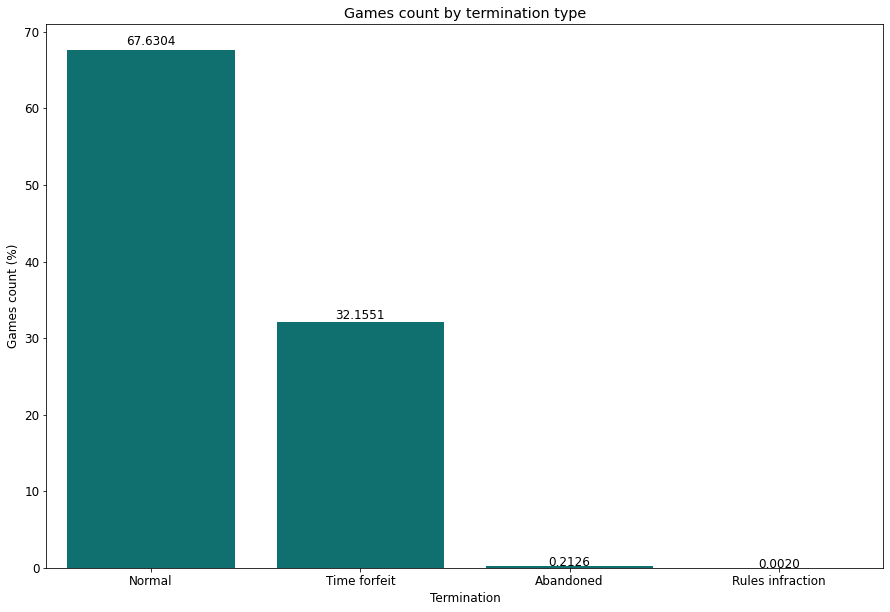

In [16]:
terminations = df.groupby('Termination')['Termination'].count().reset_index(name='Termination count').sort_values(by=['Termination count'], ascending=False)
terminations['Game percentage'] = (terminations['Termination count'] / games_count) * 100

chart = sns.barplot(x='Termination', y='Game percentage', data=terminations, color='teal')
plt.title('Games count by termination type')
plt.xlabel('Termination')
plt.ylabel('Games count (%)')
show_values(chart, whole_number = False)

The chart shows that the most popular way a game end is via mate. The hypothesis is correct.

## White piece players win more than black piece players.
In Chess the white piece player always goes first and it could be stated that this gives the white pice player an advantage. In order to test this hypothesis all victories by white and black piece players were counted and the winning percantages of players were also counted. The games were grouped by ELO groups in order to test this hypothesis. The results are shown in a line chart.

In [17]:
elo_groups_games_count = (df.groupby((df['WhiteElo']//200)*200)['WhiteElo'].count()).reset_index(name='Games count')

black_winners = df[df['Winner'] == 'Black']
black_wins_by_elo_group = black_winners.groupby((black_winners['WhiteElo']//200)*200)['WhiteElo'].count().reset_index(name='Black wins')

white_winners = df[df['Winner'] == 'White']
white_wins_by_elo_group = white_winners.groupby((white_winners['WhiteElo']//200)*200)['WhiteElo'].count().reset_index(name='White wins')

all_wins_by_elo_group = pd.merge(white_wins_by_elo_group, black_wins_by_elo_group, left_on='WhiteElo', right_on='WhiteElo', how='inner')
elo_groups_games_count = pd.merge(elo_groups_games_count, all_wins_by_elo_group, on='WhiteElo', how='inner')
elo_groups_games_count['White win%'] = (elo_groups_games_count['White wins'] / elo_groups_games_count['Games count']) * 100
elo_groups_games_count['Black win%'] = (elo_groups_games_count['Black wins'] / elo_groups_games_count['Games count']) * 100

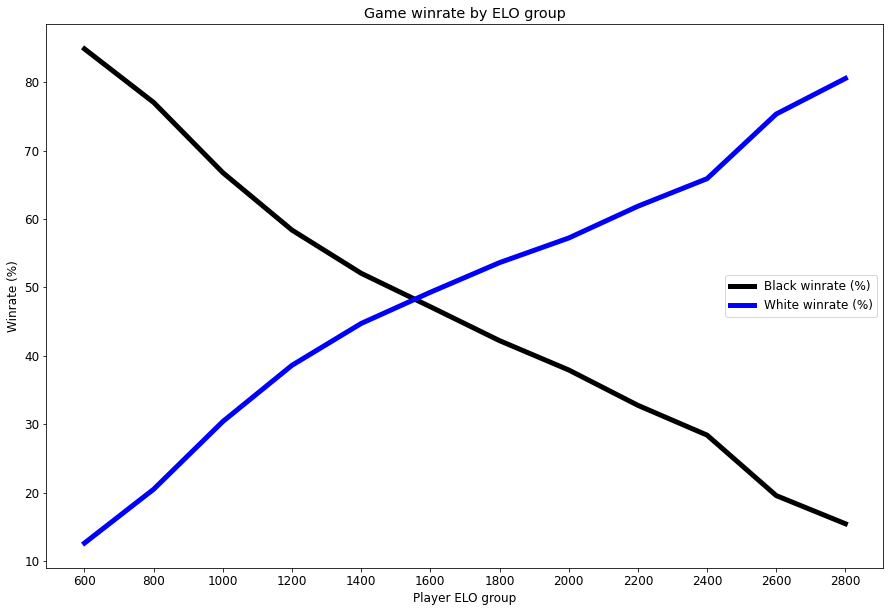

In [18]:
elo_groups = elo_groups_games_count['WhiteElo'].values
black_win_percent = elo_groups_games_count['Black win%'].values
white_win_percent = elo_groups_games_count['White win%'].values

plt.plot(elo_groups, black_win_percent, label = "Black winrate (%)", lw=5, color='black')
plt.plot(elo_groups, white_win_percent, label = "White winrate (%)", lw=5, color='blue')
plt.legend(loc=5)
plt.title('Game winrate by ELO group')
plt.ylabel('Winrate (%)')
plt.xlabel('Player ELO group')
plt.xticks(elo_groups)
plt.show()


The chart shows that the hypothesis is correct only when the player ELO is higher than 1550. That may be due to the fact that lower ranking players don't have the skill to take advantage of going first.